# Introduction to Software Bill Of Materials Dependency Analysis

**Note** For a detailed introduction to Software Bill Of Materials please click read [Intro to Software Bill Of Materials](./00-Intro-to-Software-Bill-Of-Materials.ipynb)

Software Bill of Materials (SBOM) contain details about the components and dependencies that make up a piece of software. This includes libraries, frameworks, modules, and more.  Loading SBOM files into a graph provides an efficient mechanism to explore common SBOM use cases such as Dependency Analysis.  Understanding dependencies allows teams to identify security vulnerabilities or licensing issues that may arise from open source or third-party code used in their software. Vulnerable dependencies are a major source of risk.  Dependency analysis provides visibility into all the direct and transitive dependencies used in a project. This allows security, legal, and development teams to gain a comprehensive inventory of the open source being utilized.

During development and maintenance, dependency analysis helps prevent out-of-date or vulnerable components from entering the software supply chain. It supports enforcing policies around usage of open source and third-party code.  When issues are found in upstream dependencies, analysis of SBOMs allows faster remediation as the impacted downstream software products and versions can be quickly identified from their bill of materials. At an organizational-level, SBOMs and dependency analysis support understanding third-party usage, reducing duplicate work, optimizing licensing expenditure, preventing vendor lock-in, and improving software supply chain security.

In summary, dependency analysis of SBOMs grants security and transparency into the software supply chain, allowing teams to efficiently mitigate risks introduced through use of third-party and open source components.

## Data Model

**Note** The data model being used has been covered in [Intro to Software Bill Of Materials](./00-Intro-to-Software-Bill-Of-Materials.ipynb) so please read that to get a deeper understanding of the summary presented below.

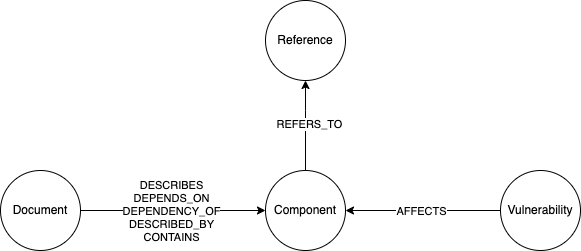

**Node Types**
* `Document` - This represents the SBOM document as well as the metadata associated with that SBOM.
* `Component` - This represents a specific component of a software system.
* `Reference` - This represents a reference to any external system which the system wanted to include as a reference.  This can range from package managers, URLs to external websites, etc.
* `Vulnerability` - This represents a specific known vulnerability for a component. 

**Edge Types**
* `DESCRIBES`/`DEPENDS_ON`/`DEPENDENCY_OF`/`DESCRIBED_BY`/`CONTAINS` - This represents the type of relationship between a `Document` and a `Component` in the system. 
* `REFERS_TO` - This represents a reference between a `Component` and a `Reference`
* `AFFECTS` - This represents that a particular `Component` is affected by the connected `Vulnerability`


## Loading SBOM Data

In this notebook we will use the [sbom_writer](./code/sbom_writer.py) Python module provided to load several SPDX files which were sourced from Github using it's SBOM feature, detailed [here](https://docs.github.com/en/rest/dependency-graph/sboms).  The including files for this notebook are:

* [AWS Graph Explorer](https://github.com/aws/graph-explorer)
* [Graph Notebook](https://github.com/aws/graph-notebook)
* [AWS SDK For pandas](https://github.com/aws/aws-sdk-pandas)
* [boto3](https://github.com/boto/boto3)

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  
If you would like to import your own SBOM files, this can be done by either saving them, in JSON format, to the `./example_sboms/01/` directory or by changing the directory location in the code below.
</details>
</div>

In [ ]:
import json
import os
import graph_notebook as gn
from code import sbom_writer as sbom

# Retrieve the notebook configuration information to pass in as parameters
config = gn.configuration.get_config.get_config()
graph_identifier = config.host.split('.')[0]
region = config.aws_region

# Create the SBOM writer
writer = sbom.NeptuneAnalyticsSBOMWriter(graph_identifier, region)

# Recursively write all the examples to graph
directory = "./example_sboms/01/"
for f in os.listdir(directory):
    if f.endswith(".json") or f.endswith(".txt"):
        with open(os.path.join(directory, f)) as file:
            print(f"Writing file {f}")
            data = json.load(file)
            writer.write_sbom(data)

print(f"Import Complete")

## Dependency Management

Now that we have completed importing these SBOM files, let's begin by visualizing what the graph of an SBOM.

### Graph of components for the `graph-notebook`

In [ ]:
%%oc  -d name

MATCH p=(n:Document {name: 'com.github.aws/graph-notebook'})-[]->()
RETURN p

Now, let's take a look at the entire SBOM for this project.

### Graph of entire SBOM for the `graph-notebook`

In [ ]:
%%oc -d name

MATCH p=(n:Document {name: 'com.github.aws/graph-notebook'})-[*1..2]->()
RETURN p

## Shared Dependencies

Another common use case with multiple SBOM's is to analyze and investigate shared dependencies across projects.  Shared dependencies allow development and security teams to better understand the security posture of the organization through identification of shared risks.  Let's start by taking a look at all the shared dependencies between these projects.

### Viewing shared dependencies

In [ ]:
%%oc -d name

MATCH p=(d1:Document)-[r]->(c:Component)<-[]-(d2:Document)
WHERE d1 <> d2
RETURN p

Now, let's take a look at the top 10 most shared dependencies.

### Which is the most shared dependency

In [ ]:
%%oc --store-to degree_data

MATCH (n:Component)
CALL neptune.algo.degree(n, {traversalDirection: 'both', edgeLabels: ['DEPENDS_ON']})
YIELD node, degree
RETURN node.name, degree
ORDER BY degree DESC 
LIMIT 10

Now that we know the most often shared dependency, let's take a look at the projects that share this dependency.

### Let's investigate this shared dependency's connections

In [ ]:
params = {'name': degree_data['results'][0]['node.name']}

In [ ]:
%%oc -qp params -d name

MATCH p=(n: Component {name: $name})<-[:DEPENDS_ON]-()
RETURN p

As we see, all four of our projects depend on the same component.  This sort of information is valuable during development and maintenance to prevent out-of-date or vulnerable components from entering the software supply chain.

## Cyclic Dependencies

Cyclic dependencies refer to situations where two or more components depend on each other in a circular fashion. For example, component A depends on component B, which in turn depends on component C, which then depends back on component A.

Identifying cyclic dependencies is important for a few reasons:

* It highlights potential design issues - cyclic dependencies make code more tightly coupled and harder to maintain.

* It impacts security vulnerability analysis - if one component has a vulnerability, all cyclically dependent components could be impacted.

* It aids refactoring and restructuring efforts - breaking down cyclic groups into more hierarchical structures.

Overall, analyzing cyclical dependencies in SBOMs provides insights into the architecture, security, and license compliance of large modern applications with many interconnected components. Removing cycles when possible leads to more resilient and sustainable software.

To identify cyclic dependencies in an SBOM we can leverage the fact that a well designed application will contain components that make up a [directed acyclic graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph).  A directed graph is acyclic if and only if it has no strongly connected subgraphs with more than one vertex.  A directed cycle is strongly connected and every non-trivial strongly connected component contains at least one directed cycle.  We can leverage a graph algorithm known as [Strongly Connected Components](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/scc.html) to test for these within our graph.  In this scenario we would expect that every component returned would only contain a single node.

In [ ]:
%%oc 

MATCH (n) 
WHERE NOT n:Reference
CALL neptune.algo.scc(n)
YIELD node, component
WITH component, count(node) as cnt
WHERE cnt>1
RETURN component

## Next Steps

In this notebook, we have demonstrated how to perform Dependency Analysis on SBOMs using Neptune Analytics.  While this notebook used a set of specific SBOM files the code provided in `sbom_writer.py` may also be used to load your own SBOM files, using the code below:

```
import json
import os
from code import sbom_writer as sbom

# Create the SBOM writer
writer = sbom.NeptuneAnalyticsSBOMWriter(graph_identifier, region)

# Recursively write all the examples to graph
directory = "<INSERT DIRECTORY HERE>"
for f in os.listdir(directory):
    if f.endswith(".json") or f.endswith(".txt"):
        with open(os.path.join(directory, f)) as file:
            print(f"Writing file {f}")
            data = json.load(file)
            writer.write_sbom(data)

print(f"Import Complete")
```

If you are interested in the other types of SBOM analysis please look at the other notebooks available:

* [SBOM Vulnerability Analysis](./02-SBOM-Vulnerability-Analysis.ipynb)